In [2]:
from model import FitRecSpeedPredictor

2025-05-27 18:22:47.382437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
predictor = FitRecSpeedPredictor(window_duration=30, prediction_duration=30) # Use window_duration and prediction_duration


In [6]:
# Load Endomondo data using the specified method
data = predictor.load_endomondo_data()

if data is None or data.empty:
    print("No data loaded or data is empty. Exiting.")
else:
    print("\nData sample:")
    print(data.head())
    print(f"\nData statistics:")
    print(data.describe())

Loaded data type: <class 'numpy.ndarray'>
Unknown data format: <class 'numpy.ndarray'>
Generating sample data for demonstration...

Data sample:
   timestamp     speed  heart_rate
0          0  8.496714  147.616392
1          1  7.891735  147.461660
2          2  8.707685  141.169357
3          3  9.613016  148.941786
4          4  7.885815  153.910275

Data statistics:
         timestamp        speed   heart_rate
count  5000.000000  5000.000000  5000.000000
mean   2499.500000     8.007783   139.913107
std    1443.520003     2.363840    15.529518
min       0.000000     2.104057   102.297574
25%    1249.750000     6.049130   125.973667
50%    2499.500000     7.963936   139.794542
75%    3749.250000     9.976729   153.716998
max    4999.000000    14.457375   177.739732


In [14]:
data.head()

,timestamp,speed,heart_rate
0,0,8.496714,147.616392
1,1,7.891735,147.461660
2,2,8.707685,141.169357
3,3,9.613016,148.941786
4,4,7.885815,153.910275


In [1]:
from pathlib import Path
import numpy as np

path = Path("data/")
out_path = str(path / "run_data.npy") # Assuming this path exists and contains the data
data1 = np.load(out_path, allow_pickle=True) # Use allow_pickle=True if data is stored as python objects


In [2]:
timestamp = np.array(data1[0]['timestamp'])


In [4]:
import pandas as pd


In [5]:
df=pd.DataFrame({'timestamp':timestamp})

In [6]:
df['origin_timestamp'] = df['timestamp'] - df['timestamp'].iloc[0]

In [7]:
df

,timestamp,origin_timestamp
0,1393687929,0
1,1393687948,19
2,1393687967,38
3,1393687986,57
4,1393688005,76
...,...,...
295,1393693895,5966
296,1393693914,5985
297,1393693933,6004
298,1393693952,6023


In [40]:
from fitparse import FitFile
from datetime import datetime



In [56]:
def extract_fit_data():
    # 用于存储提取数据的列表
    timestamps = []
    heart_rates = []
    speeds = []

    file_path = '5k.fit' # 确保这个文件与你的脚本在同一目录下，或者提供完整路径

    print(f"Attempting to process '{file_path}'...")

    try:
        # 加载 FIT 文件，并根据你的要求设置 check_crc=False
        # 这会尝试忽略 CRC 校验错误，但如果文件有更严重的结构问题，仍然可能失败
        fitfile = FitFile(file_path, check_crc=True)

        # 遍历文件中的 'record' 消息 (这些通常包含逐秒的数据)
        for record in fitfile.get_messages('record'):
            # 从每个记录中提取所需字段的值
            # record.get_value('field_name') 会在字段不存在时返回 None，这比直接访问更安全

            timestamp_val = record.get_value('timestamp')
            heart_rate_val = record.get_value('heart_rate')
            speed_val = record.get_value('speed') # 速度通常以 m/s 为单位
        
            # 将提取的值（即使是 None）附加到各自的列表中
            timestamps.append(timestamp_val)
            heart_rates.append(heart_rate_val)
            speeds.append(speed_val)

        # 检查是否收集到了数据
        if not timestamps:
            print("No 'record' messages found or no data extracted.")
        else:
            # 使用收集到的数据创建 pandas DataFrame
            df = pd.DataFrame({
                'timestamp': timestamps,
                'heart_rate': heart_rates,
                'speed': speeds
            })
            df=df.dropna()

            # （可选）将 timestamp 列转换为更易读的格式或设置为索引
            # fitparse 通常已经将 timestamp 解析为 datetime 对象
            # df['timestamp'] = pd.to_datetime(df['timestamp']) # 如果需要确保
            # df.set_index('timestamp', inplace=True) # 如果想把时间戳设为索引
            df['timestamp_dt'] = pd.to_datetime(df['timestamp']) # 保留原始datetime对象，方便查看
            df['speed'] = df['speed']*3.6
            # 然后转换为 Unix 时间戳 (毫秒)，并确保为64位整数类型以容纳大数值
            df['timestamp'] = df['timestamp_dt'].astype('int64') // 10**9
            # 打印 DataFrame 的信息和前几行以供查阅
            print("\nDataFrame Info:")
            df.info()
            print("\nDataFrame Head:")
            print(df.head())
            return df
            # 如果需要，你可以将 DataFrame 保存到 CSV 文件
            # df.to_csv('extracted_data.csv', index=False)
            # print("\nData saved to extracted_data.csv")

    except FitParseError as e:
        print(f"Error parsing FIT file '{file_path}': {e}")
        print("This might indicate a corrupted file or a structure that fitparse cannot handle, even with check_crc=False.")
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please check the file path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [57]:
df=extract_fit_data()
df

Attempting to process '5k.fit'...

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1269 entries, 3 to 1271
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     1269 non-null   int64         
 1   heart_rate    1269 non-null   float64       
 2   speed         1269 non-null   float64       
 3   timestamp_dt  1269 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 49.6 KB

DataFrame Head:
    timestamp  heart_rate    speed        timestamp_dt
3  1724853478        90.0   0.0000 2024-08-28 13:57:58
4  1724853479        91.0   0.0000 2024-08-28 13:57:59
5  1724853480        92.0   6.0912 2024-08-28 13:58:00
6  1724853481        94.0  12.1896 2024-08-28 13:58:01
7  1724853482        95.0  12.9708 2024-08-28 13:58:02


,timestamp,heart_rate,speed,timestamp_dt
3,1724853478,90.0,0.0000,2024-08-28 13:57:58
4,1724853479,91.0,0.0000,2024-08-28 13:57:59
5,1724853480,92.0,6.0912,2024-08-28 13:58:00
6,1724853481,94.0,12.1896,2024-08-28 13:58:01
7,1724853482,95.0,12.9708,2024-08-28 13:58:02
...,...,...,...,...
1267,1724854742,153.0,13.3092,2024-08-28 14:19:02
1268,1724854743,153.0,13.3308,2024-08-28 14:19:03
1269,1724854744,153.0,13.3488,2024-08-28 14:19:04
1270,1724854745,153.0,13.3812,2024-08-28 14:19:05


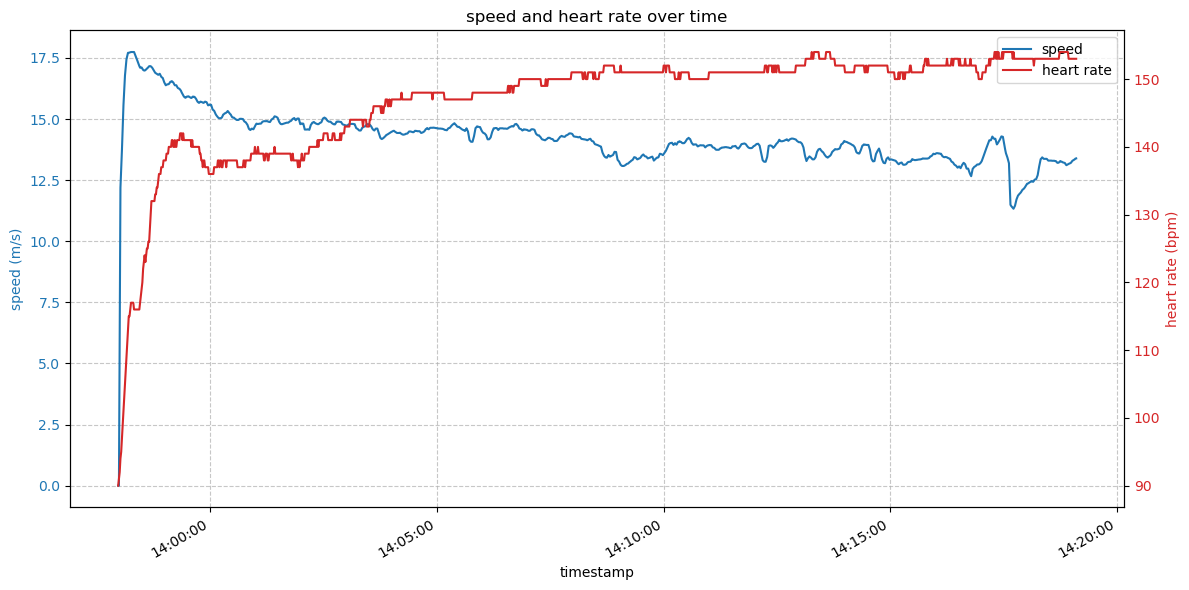

In [58]:
# 创建一个可视化图表，展示speed、heart_rate随时间变化的关系
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 创建一个带有两个Y轴的图表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 设置X轴为时间
ax1.set_xlabel('timestamp')
ax1.set_ylabel('speed (m/s)', color='tab:blue')

# 绘制速度数据
ax1.plot(df['timestamp_dt'], df['speed'], color='tab:blue', label='speed')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 创建第二个Y轴
ax2 = ax1.twinx()
ax2.set_ylabel('heart rate (bpm)', color='tab:red')

# 绘制心率数据
ax2.plot(df['timestamp_dt'], df['heart_rate'], color='tab:red', label='heart rate')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 设置X轴格式
plt.gcf().autofmt_xdate()  # 自动格式化X轴日期标签
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # 时:分:秒格式

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 添加标题
plt.title('speed and heart rate over time')

# 添加网格线
ax1.grid(True, linestyle='--', alpha=0.7)

# 调整布局
fig.tight_layout()

# 显示图表
plt.show()
